In [47]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2 
import albumentations as alb
from tensorflow.keras import layers

import os
import json
import time
import random
import uuid
import sys
sys.path.append("../")

from helper_functions import *

## Limit GPU Memory Growth

In [48]:
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [49]:
TRAIN_IMAGES_PATH = os.path.join("..", "data", "face_localization_data", "train", "images")
num_images = 20

# Take images 

In [35]:
#take_pictures(num_images, TRAIN_IMAGES_PATH) # custom function from helper_functions

You have 5 seconds to take your headphones off, and change position


## Annotate the images

In [32]:
!labelme

[INFO   ] __init__:get_config:71 - Loading config file from: /Users/andriievskyi/.labelmerc


## Split the images and labels into train/val/test folders

In [50]:
train_size = int(len(os.listdir(TRAIN_IMAGES_PATH)) * 0.7)
val_size = int(len(os.listdir(TRAIN_IMAGES_PATH)) * 0.15) + 1
test_size = int(len(os.listdir(TRAIN_IMAGES_PATH)) * 0.15) + 1

train_size, val_size, test_size 

(79, 18, 18)

In [35]:
images_paths = os.listdir(TRAIN_IMAGES_PATH)
random.shuffle(images_paths)

# for i in images_paths[:val_size]:
#     os.system(f"mv {os.path.join(TRAIN_IMAGES_PATH, i)} {os.path.join('..', 'data', 'face_localization_data', 'val', 'images')}")

# for i in images_paths[:test_size]:
#      os.system(f"mv {os.path.join(TRAIN_IMAGES_PATH, i)} {os.path.join('..','data', 'face_localization_data', 'test', 'images')}")
        
        

## Augment the data

In [52]:
augmentor = alb.Compose([
    alb.HorizontalFlip(p=0.4),
    alb.RandomBrightnessContrast(p=0.3),
    alb.RandomGamma(p=0.2),
    alb.RGBShift(p=0.2),
    alb.VerticalFlip(p=0.4)],
    bbox_params=alb.BboxParams(format="albumentations", label_fields=["class_labels"])
)

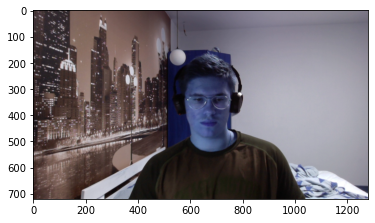

In [60]:
img = cv2.imread(os.path.join(TRAIN_IMAGES_PATH, "18:12:30.jpeg"))
plt.imshow(img);

In [62]:
with open(os.path.join("..","data", "face_localization_data", "train", "labels","18:12:30.json")) as f:
    label = json.load(f)
    

    

In [63]:
coords = [j for i in label["shapes"][0]["points"] for j in i]
coords = list(np.divide(coords, [1280, 720, 1280, 720]))
coords

[0.4173491379310345,
 0.23703703703703702,
 0.6220905172413793,
 0.6792464878671775]

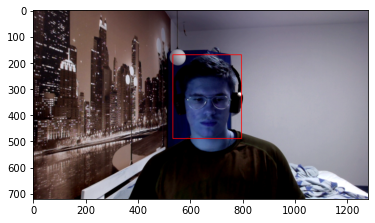

In [64]:
augmented_img = augmentor(image=img, bboxes=[coords], class_labels=["face"])

cv2.rectangle(
    augmented_img["image"],
    tuple(np.multiply(augmented_img["bboxes"][0][:2], [1280, 720]).astype(int)),
    tuple(np.multiply(augmented_img["bboxes"][0][2:], [1280, 720]).astype(int)),
    (255,0,0), 2)

plt.imshow(augmented_img["image"]);

## Move the Matching labels

In [65]:
# for folder in ["val", "test"]:
#    for file in os.listdir(os.path.join("..","data", "face_localization_data", folder, "images")):
       
#        filename = file.split(".")[0]+".json"
#        existing_filepath = os.path.join("..","data", "face_localization_data","train", "labels", filename)
       
#        if os.path.exists(existing_filepath):
#            new_filepath = os.path.join("..","data", "face_localization_data", folder, "labels", filename)
#            os.replace(existing_filepath, new_filepath)

## Create Augmented Data

In [68]:
# for partition in ['train','test','val']: 
#     for image in os.listdir(os.path.join('..','data','face_localization_data', partition, 'images')):
#         img = cv2.imread(os.path.join('..','data','face_localization_data', partition, 'images', image))

#         coords = [0,0,0.00001,0.00001]
#         label_path = os.path.join('..','data','face_localization_data', partition, 'labels', f'{image.split(".")[0]}.json')
#         if os.path.exists(label_path):
#             with open(label_path, 'r') as f:
#                 label = json.load(f)

#             coords = [j for i in label["shapes"][0]["points"] for j in i]
#             coords = list(np.divide(coords, [1280, 720, 1280, 720]))

#         try: 
#             for x in range(60):
#                 augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
#                 cv2.imwrite(os.path.join('..','aug_data', 'aug_face_localization_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

#                 annotation = {}
#                 annotation['image'] = image

#                 if os.path.exists(label_path):
#                     if len(augmented['bboxes']) == 0: 
#                         annotation['bbox'] = [0,0,0,0]
#                         annotation['class'] = 0 
#                     else: 
#                         annotation['bbox'] = augmented['bboxes'][0]
#                         annotation['class'] = 1
#                 else: 
#                     annotation['bbox'] = [0,0,0,0]
#                     annotation['class'] = 0 


#                 with open(os.path.join('..','aug_data','aug_face_localization_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
#                     json.dump(annotation, f)

#         except Exception as e:
#             print(e)

## Create datasets

In [74]:
def load_image(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img)
    
    return img

### Create image datasets

In [88]:
train_images = tf.data.Dataset.list_files(
    os.path.join("..", "aug_data", "aug_face_localization_data", "train", "images", "*.jpg"),
    shuffle=False)

train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (224,224)))
train_images = train_images.map(lambda x: x/255)

In [90]:
val_images = tf.data.Dataset.list_files(
    os.path.join("..", "aug_data", "aug_face_localization_data", "val", "images", "*.jpg"), 
    shuffle=False)

val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (224,224)))
val_images = val_images.map(lambda x: x/255)

In [91]:
test_images = tf.data.Dataset.list_files(
    os.path.join("..", "aug_data", "aug_face_localization_data", "test", "images", "*.jpg"), 
    shuffle=False)

test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (224,224)))
test_images = test_images.map(lambda x: x/255)

### Create label datasets

In [95]:
def load_labels(path):
    with open(path.numpy(), "r", encoding="utf-8") as f:
        label = json.load(f)
        
    return [label["class"], label["bbox"]]

In [96]:
train_labels = tf.data.Dataset.list_files(
    os.path.join("..", "aug_data", "aug_face_localization_data", "train", "labels", "*.json"), 
    shuffle=False)

train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))


In [97]:
val_labels = tf.data.Dataset.list_files(
    os.path.join("..", "aug_data", "aug_face_localization_data", "val", "labels", "*.json"), 
    shuffle=False)

val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [98]:
test_labels = tf.data.Dataset.list_files(
    os.path.join("..", "aug_data", "aug_face_localization_data", "test", "labels", "*.json"), 
    shuffle=False)

test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

## Combine the image and label datasets into one for train, val and test

In [99]:
train_data = tf.data.Dataset.zip((train_images, train_labels))
train_data = train_data.shuffle(len(train_images) + 1000)
train_data = train_data.batch(32)
train_data = train_data.prefetch(tf.data.AUTOTUNE)


In [102]:
val_data = tf.data.Dataset.zip((val_images, val_labels))
val_data = val_data.shuffle(len(val_images) + 1000)
val_data = val_data.batch(32)
val_data = val_data.prefetch(tf.data.AUTOTUNE)

In [103]:
test_data = tf.data.Dataset.zip((test_images, test_labels))
test_data = test_data.shuffle(len(test_images) + 1000)
test_data = test_data.batch(32)
test_data = test_data.prefetch(tf.data.AUTOTUNE)